# 🔍 Predicting Item Prices from Descriptions (Part 3)

---
-  Data Curation & Preprocessing
- Model Benchmarking – Traditional ML vs LLMs
- ➡️E5 Embeddings & RAG
- Fine-Tuning GPT-4o Mini
- Evaluating LLaMA 3.1 8B Quantized
- Fine-Tuning LLaMA 3.1 with QLoRA
- Evaluating Fine-Tuned LLaMA
- Summary & Leaderboard

---

# 🧠 Part 3: E5 Embeddings & RAG 

- ⚙️ Hardware: ⚠️ GPU required for embeddings (400K items) - use Google Colab
- 🛠️ Requirements: 🔑 HF Token, Open API Key
- Tasks:
    - Preprocessed item descriptions
    - Generated and stored embeddings in ChromaDB
    - Trained XGBoost on embeddings
    - Predicted prices with GPT-4o Mini using RAG

Is Word2Vec enough for XGBoost, or do contextual E5 embeddings perform better?

Does retrieval improve price prediction for GPT-4o Mini?

Let’s find out.

⚠️ This notebook assumes basic familiarity with RAG and contextual embeddings.
We use the same E5 embedding space for both XGBoost and GPT-4o Mini with RAG, enabling a fair comparison.
Embeddings are stored and queried via ChromaDB — no LangChain is used for creation or retrieval.


In [2]:
!pip install -q tqdm python-dotenv huggingface_hub numpy sentence-transformers datasets chromadb xgboost

In [27]:
# imports

import math, chromadb, re, joblib
from tqdm import tqdm
from huggingface_hub import login
import numpy as np
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from google.colab import userdata
from xgboost import XGBRegressor
from openai import OpenAI
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Load from Colab's secure storage
openai_api_key = userdata.get("OPENAI_API_KEY")

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

# Configuration
CHROMA_PATH = "vector_db/chroma_price"

In [22]:
# Helper class for evaluating model predictions

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        # print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)

        # Add color legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Accurate (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Medium error (orange)', markerfacecolor='orange', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='High error (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.show()


    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()



# 📥 Load Dataset

In [6]:
HF_USER = "Lizk75"
DATASET_NAME = f"{HF_USER}/pricer-data"

dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/905k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
print(train[0]["text"])

How much does this cost to the nearest dollar?

Detail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon
The TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new

Price is $130.00


In [9]:
print(train[0]["price"])

129.95


# 📦 Embed + Save Training Data to Chroma
- No LangChain used.
- We use `intfloat/e5-small-v2` for embeddings:
    - Fast, high-quality, retrieval-tuned
    - **Requires 'passage:' prefix**
- We embed item descriptions and store them in ChromaDB, with price saved as metadata.

In [10]:
# Load embedding model
model_embedding = SentenceTransformer("intfloat/e5-small-v2", device='cuda')

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [11]:
# Init Chroma
client = chromadb.PersistentClient(path=CHROMA_PATH)
collection = client.get_or_create_collection(name="price_items")

In [12]:
# Format description function (no price in text)
def description(item):
    text = item["text"].replace("How much does this cost to the nearest dollar?\n\n", "")
    text = text.split("\n\nPrice is $")[0]
    return f"passage: {text}"

description(train[0])

'passage: Detail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon\nThe TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new'

In [15]:
batch_size = 1000

for i in tqdm(range(0, len(train), batch_size)):

    # Get batch indices
    end_idx = min(i + batch_size, len(train))

    # Create lists to collect batch data
    documents = []
    vectors_input = []
    items = []

    # Collect items for this batch
    for j in range(i, end_idx):
        item = train[j]
        doc = description(item)
        documents.append(doc)
        vectors_input.append(doc)
        items.append(item)

    # Batch encode all at once
    vectors = model_embedding.encode(vectors_input, batch_size=128, show_progress_bar=False).tolist()

    # Prepare metadata and IDs
    metadatas = [{"price": item["price"]} for item in items]
    ids = [f"doc_{j}" for j in range(i, end_idx)]

    # Add to collection
    collection.add(
        ids=ids,
        documents=documents,
        embeddings=vectors,
        metadatas=metadatas
    )

print("✅ Embedding and storage to ChromaDB completed.")

100%|██████████| 400/400 [41:08<00:00,  6.17s/it]

✅ Embedding and storage to ChromaDB completed.


🧩 Now that we've generated the E5 embeddings, let's use them for both **XGBoost regression** and **GPT-4o Mini with RAG** .

# 📈 Embedding-Based Regression with XGBoost

In [16]:
# Step 1: Load vectors and prices from Chroma
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [meta['price'] for meta in result['metadatas']]


In [ ]:
# Step 2: Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
xgb_model.fit(vectors, prices)

In [ ]:
joblib.dump(xgb_model, "xgb_price_model.pkl") # Save model for future use
xgb_model = joblib.load("xgb_price_model.pkl") # Load the model

In [24]:
# Step 3: Define the predictor
def xgb_predictor(datapoint):
    doc = description(datapoint)
    vector = model_embedding.encode([doc])[0]
    return max(0, xgb_model.predict([vector])[0])

🔔 Reminder: In Part 2, XGBoost with Word2Vec (non-contextual embeddings) achieved:
- Avg. Error: ~$105.99
- RMSLE: 0.87
- Accuracy: 33.6%

🧪 Now, let’s see if contextual embeddings improve XGBoost.

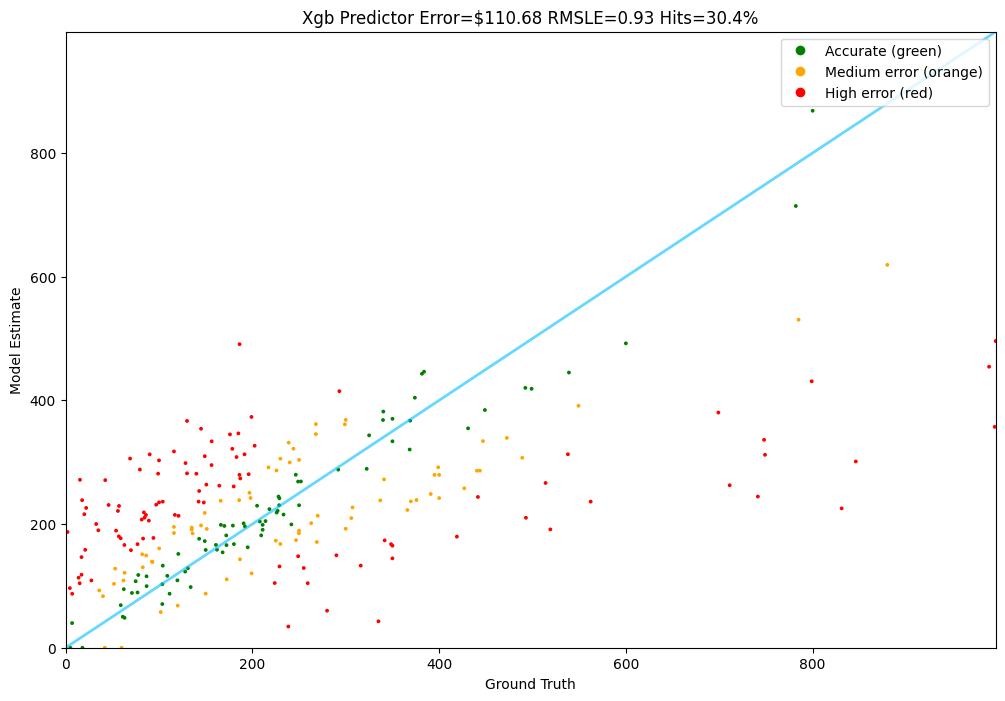

In [25]:
# Step 4: Run the Tester on a subset of test data
tester = Tester(xgb_predictor, test)
tester.run()

Results are nearly the same. In this setup, switching to contextual embeddings didn’t yield performance gains for XGBoost.

# 🚰 Retrieval-Augmented Pipeline – GPT-4o Mini

- Preprocess: clean the input text (description(item))
- Embed: generate embedding vector (get_embedding(item))
- Retrieve: find similar items from ChromaDB (find_similar_items)
- Build Prompt: create the LLM prompt using context and masked target (build_messages)
- Predict: get price estimate from LLM (estimate_price)

In [28]:
# Step 0: Init
openai = OpenAI(api_key=openai_api_key)

In [43]:
test[1]

{'text': 'How much does this cost to the nearest dollar?\n\nAKKON - For Chevy Trailblazer Black OE Replacement Headlights Driver/Passenger Head Lamps Pair\nThis is a 100% brand new pair of Headlights Replacement Assemblies in Midnight Black Housing With Crystal Clear LensCompatible With 02-09 Chevy Trailblazer All Models Fits Chevy Trail Blazer All Model 100% Brand New, Comes in a Pair, Which Means Included Left Side (Driver Side) & Right Side (Passenger Side) Direct Bolt On Replacement For Your Original Headlights, No Wiring or Any Other Modification Needed 90 Days Limited Warranty from the date of the shipment shows delivered, No exception Unless Otherwise Noted, Our Lights Do Not Include Bulbs, Though Occasionally Lighting Manufacturers Do Include Bulbs in the Lights. Brand AKKON, Color Black Housing,\n\nPrice is $',
 'price': 115.99}

In [45]:
# Step 1: Preprocess test item text
# (uses the same `description(item)` function as during training)
description(test[1])

'passage: AKKON - For Chevy Trailblazer Black OE Replacement Headlights Driver/Passenger Head Lamps Pair\nThis is a 100% brand new pair of Headlights Replacement Assemblies in Midnight Black Housing With Crystal Clear LensCompatible With 02-09 Chevy Trailblazer All Models Fits Chevy Trail Blazer All Model 100% Brand New, Comes in a Pair, Which Means Included Left Side (Driver Side) & Right Side (Passenger Side) Direct Bolt On Replacement For Your Original Headlights, No Wiring or Any Other Modification Needed 90 Days Limited Warranty from the date of the shipment shows delivered, No exception Unless Otherwise Noted, Our Lights Do Not Include Bulbs, Though Occasionally Lighting Manufacturers Do Include Bulbs in the Lights. Brand AKKON, Color Black Housing,'

In [29]:
# Step 2: Embed a test item
def get_embedding(item):
    return model_embedding.encode([description(item)])

In [30]:
# Step 3: Query Chroma for similar items
def find_similars(item):
    results = collection.query(query_embeddings=get_embedding(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [38]:
documents, prices = find_similars(test[1])
documents, prices

(['passage: AKKON - For Chevy Malibu OE Replacement Black Bezel Headlights Driver/Passenger Head Lamps Pair New\nThis is a 100% brand new pair of Headlights Replacement Assemblies in Midnight Black Housing With Crystal Clear LensCompatible With 08-12 Chevy Malibu All Models Fits Chevy Malibu 100% Brand New, Comes in a Pair, Which Means Included Left Side (Driver Side) & Right Side (Passenger Side) Direct Bolt On Replacement For Your Original Headlights, No Wiring or Any Other Modification Needed 90 Days Limited Warranty from the date of the shipment shows delivered, No exception Unless Otherwise Noted, Our Lights Do Not Include Bulbs, Though Occasionally Lighting Manufacturers Do Include Bulbs in the Lights. Brand AKKON, Color Black Housing, Specific Uses',
  'passage: AKKON - For Black 08-12 Pathfinder Headlights Head Lamps Front Lamps Direct Replacement Pair Left + Right\nThis is a 100% brand new pair of Headlights Replacement Assemblies in Midnight Black Housing With Crystal Clear L

In [39]:
# Step 4: Format similar items as context
def format_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [40]:
print(format_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
passage: AKKON - For Chevy Malibu OE Replacement Black Bezel Headlights Driver/Passenger Head Lamps Pair New
This is a 100% brand new pair of Headlights Replacement Assemblies in Midnight Black Housing With Crystal Clear LensCompatible With 08-12 Chevy Malibu All Models Fits Chevy Malibu 100% Brand New, Comes in a Pair, Which Means Included Left Side (Driver Side) & Right Side (Passenger Side) Direct Bolt On Replacement For Your Original Headlights, No Wiring or Any Other Modification Needed 90 Days Limited Warranty from the date of the shipment shows delivered, No exception Unless Otherwise Noted, Our Lights Do Not Include Bulbs, Though Occasionally Lighting Manufacturers Do Include Bulbs in the Lights. Brand AKKON, Color Black Housing, Specific Uses
Price is $115.99

Potentially related product:
passage: AKKON - For Black 08-12 Pathfinder Headlights

In [50]:
# Step 5: Mask the price in the test item
def mask_price_value(text):
    return re.sub(r"(\n\nPrice is \$).*", r"\1", text)

In [51]:
# Step 6: Build LLM messages
def build_messages(datapoint, similars, prices):

    system_message = "You estimate prices of items. Reply only with the price, no explanation."

    context = format_context(similars, prices)

    prompt = mask_price_value(datapoint["text"])
    prompt = prompt.replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")

    user_prompt = context + "And now the question for you:\n\n" + prompt

    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [53]:
build_messages(test[1], documents, prices)

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation.'},
 {'role': 'user',
  'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\npassage: AKKON - For Chevy Malibu OE Replacement Black Bezel Headlights Driver/Passenger Head Lamps Pair New\nThis is a 100% brand new pair of Headlights Replacement Assemblies in Midnight Black Housing With Crystal Clear LensCompatible With 08-12 Chevy Malibu All Models Fits Chevy Malibu 100% Brand New, Comes in a Pair, Which Means Included Left Side (Driver Side) & Right Side (Passenger Side) Direct Bolt On Replacement For Your Original Headlights, No Wiring or Any Other Modification Needed 90 Days Limited Warranty from the date of the shipment shows delivered, No exception Unless Otherwise Noted, Our Lights Do Not Include Bulbs, Though Occasionally Lighting Manufacturers Do Include Bulbs in the Lights. Bra

In [56]:
# Step 7: Run prediction
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=build_messages(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [57]:
print(test[1]["price"])
print(gpt_4o_mini_rag(test[1]))

115.99
99.99


🔔 Reminder: In Part 2, GPT-4o Mini (without RAG) achieved:
- Avg. Error: ~$100
- RMSLE: 0.75
- Accuracy: 43.6%

🧪 Let’s find out if RAG can boost GPT-4o Mini’s price prediction capabilities.
  

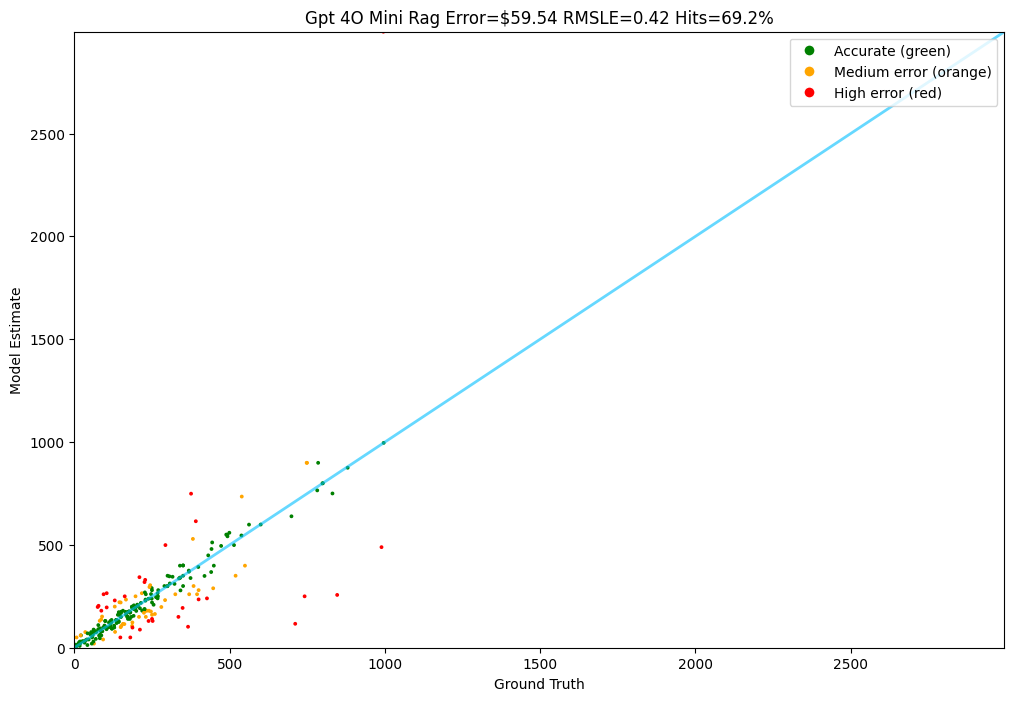

In [58]:
Tester.test(gpt_4o_mini_rag, test)

🎉 **GPT-4o Mini + RAG shows clear gains:**  
Average error dropped from **$100 → $59.54**, RMSLE from **0.75 → 0.42**, and accuracy rose from **43.6% → 69.2%**.  

Adding retrieval-based context led to a strong performance boost for GPT-4o Mini.

Now the question is — can fine-tuning push it even further, surpass RAG, and challenge larger models?

🔜 See you in the next notebook.